# Import libs

In [1]:
import sys

sys.path.append("..")
from data.SythGenetator import SinusoidTraffic
from models.sst import SingularSequenceTransformation
from optimization.WindowFinders import WindowSizeSelection

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# Load Data

In [31]:
data = SinusoidTraffic(coeff_anomaly=1.5).generate_dataset() #change coeff param to 1 equal to generate normal ts

In [32]:
data.head()

,sinusoid_values_from_an_object
2023-09-01 00:00:00,0.025352
2023-09-01 01:00:00,0.197192
2023-09-01 02:00:00,0.322973
2023-09-01 03:00:00,0.564906
2023-09-01 04:00:00,0.719355


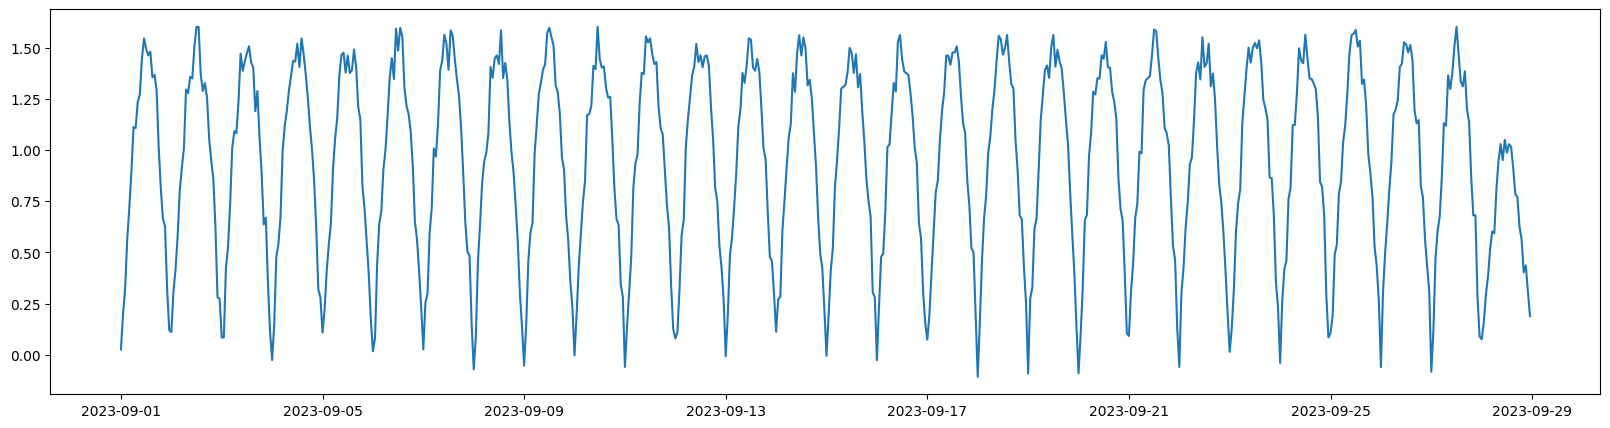

In [33]:
plt.figure(figsize=(20,5))
plt.plot(data)

# Search Window Param

In [34]:
window_size = WindowSizeSelection(time_series=data.values.ravel()).runner_wss()[0]

In [35]:
print('window size:', window_size)

window size: 28


# Define Model

In [36]:
model = SingularSequenceTransformation(df=data)

#### online mode, sigmoid false

In [37]:
online_res = abs(SingularSequenceTransformation(df=data, is_online=True,
                                            window_length=24, is_sigmoid=False).runner(data.columns[0]).values)

online_res_sigmoid = abs(SingularSequenceTransformation(df=data, is_online=True,
                                            window_length=24, is_sigmoid=True).runner(data.columns[0]).values)

#### offline mode, sigmoid false

In [38]:
offline_res = abs(SingularSequenceTransformation(df=data, is_online=False, window_length=window_size,
                                            is_sigmoid=False,).runner(data.columns[0]).values)

# Plot SST results

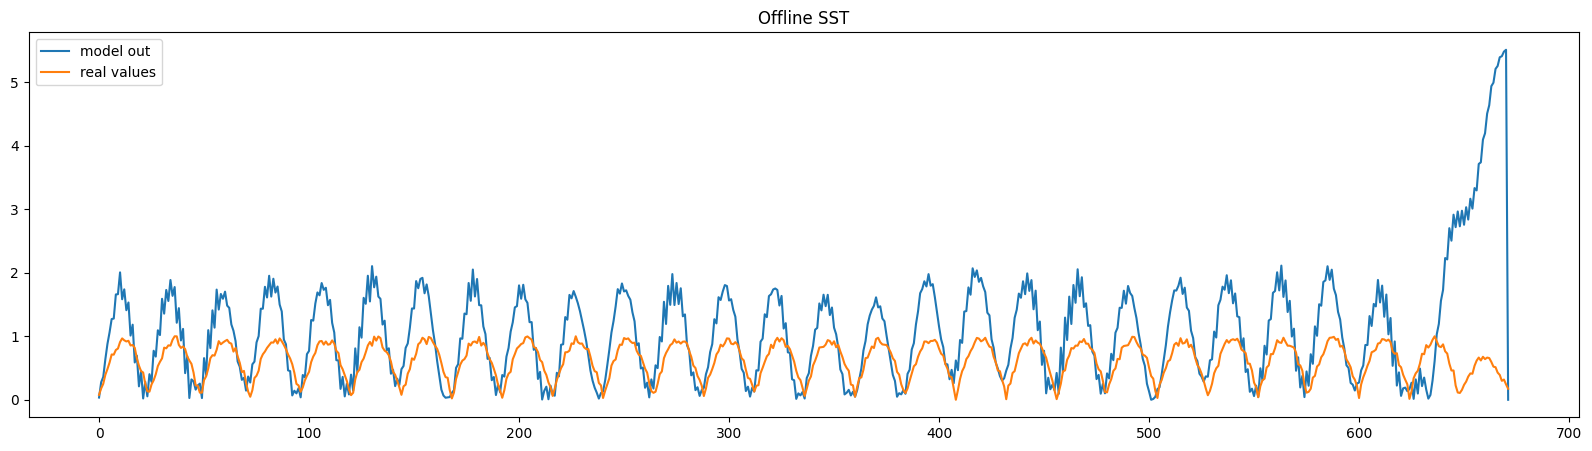

In [39]:
plt.figure(figsize=(20,5))
plt.title('Offline SST')
plt.plot(offline_res, label='model out')
plt.plot(data.values, label='real values')
plt.legend()

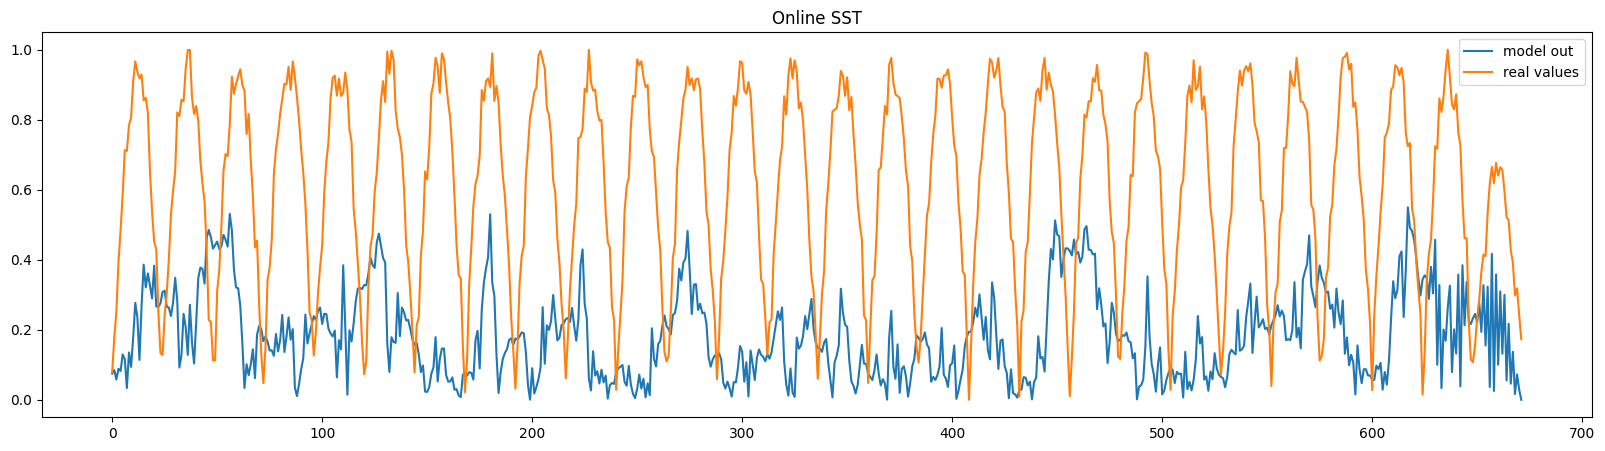

In [40]:
plt.figure(figsize=(20,5))
plt.title('Online SST')
plt.plot(online_res, label='model out')
plt.plot(data.values, label='real values')
plt.legend()

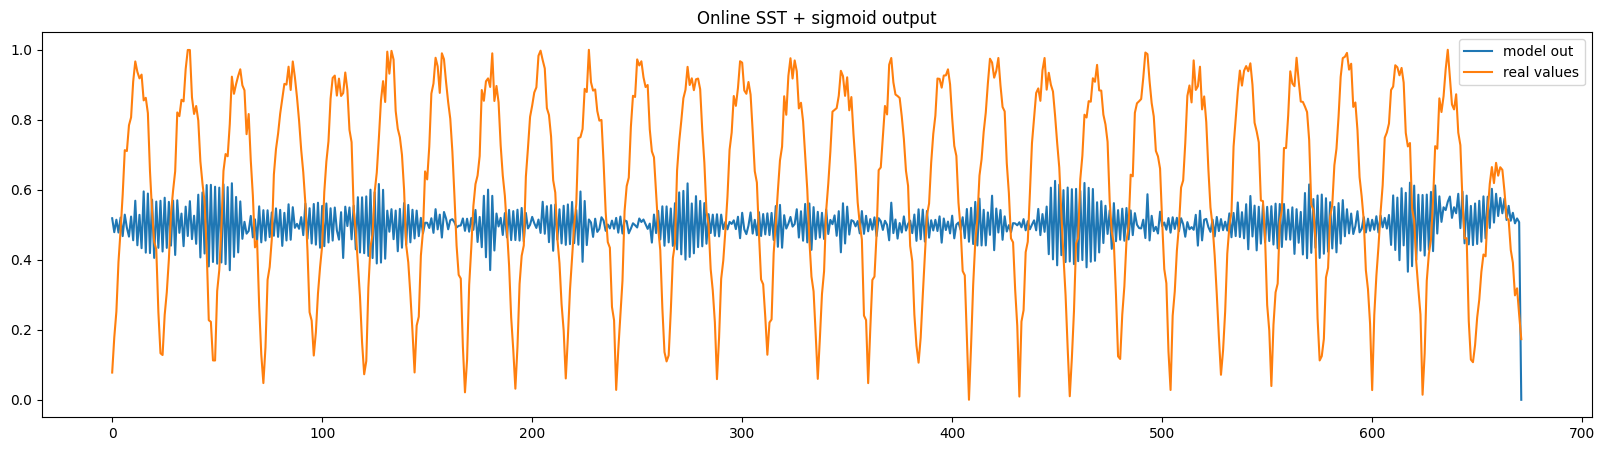

In [41]:
plt.figure(figsize=(20,5))
plt.title('Online SST + sigmoid output')
plt.plot(online_res_sigmoid, label='model out')
plt.plot(data.values, label='real values')
plt.legend()

# Find CP

In [42]:
var_list = []
for i in range(0, online_res.shape[0]-5):
    var_list.append(online_res[i:i+5].var())

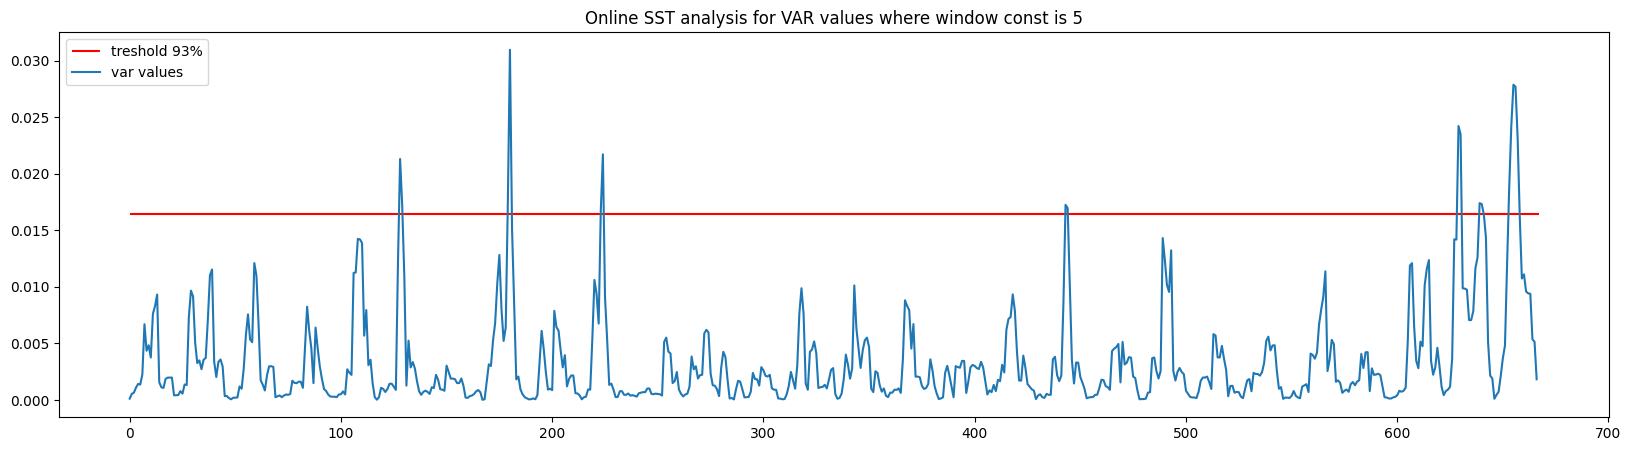

In [43]:
plt.figure(figsize=(20,5))
plt.title('Online SST analysis for VAR values where window const is 5')
plt.hlines(xmin=0, xmax=len(var_list), y=np.std(var_list)*3+np.mean(var_list), color='r', label='treshold 93%')
plt.plot(var_list, label='var values')
plt.legend()

In [44]:
treshold_var = np.std(var_list)*3 + np.mean(var_list)
index_cp_var_list = np.where(var_list > treshold_var)[0]

In [45]:
print('CP index (VAR, SST online):', index_cp_var_list)

CP index (VAR, SST online): [128 129 179 180 223 224 443 444 629 630 639 640 653 654 655 656 657]


In [46]:
mean_list_offline = []
for i in range(0, offline_res.shape[0]-window_size):
    mean_list_offline.append(offline_res[i:i+window_size].mean())

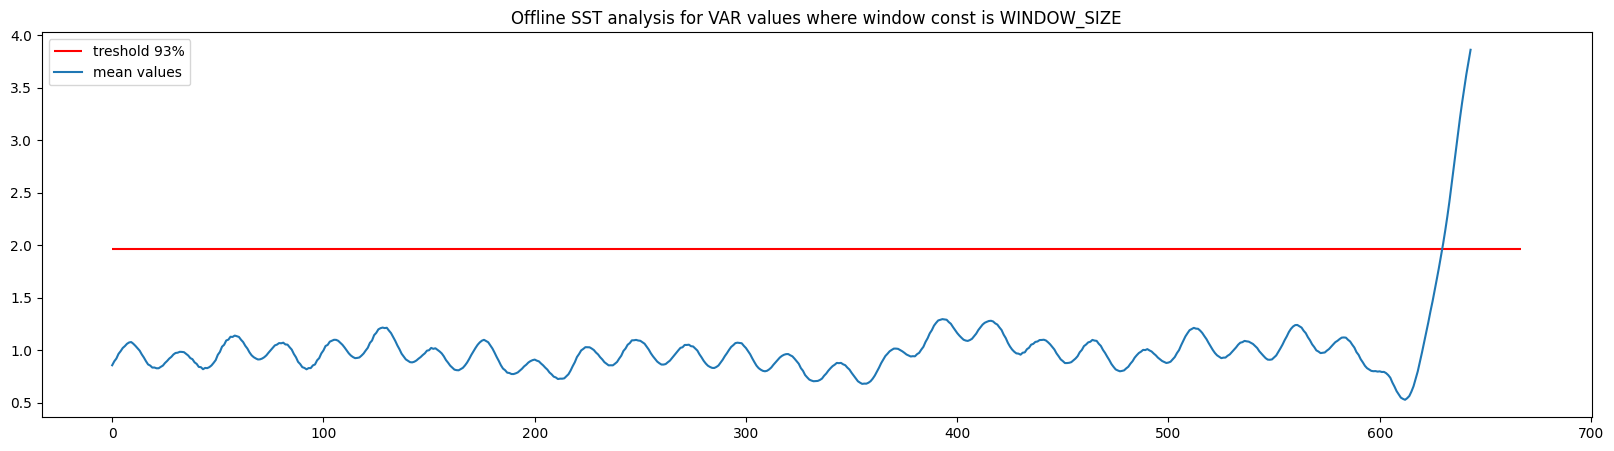

In [47]:
plt.figure(figsize=(20,5))
plt.title('Offline SST analysis for VAR values where window const is WINDOW_SIZE')
plt.hlines(xmin=0, xmax=len(var_list), y=np.std(mean_list_offline)*2.8+np.mean(mean_list_offline), color='r', label='treshold 93%')
plt.plot(mean_list_offline, label='mean values')
plt.legend()

In [48]:
treshold_mean = np.std(mean_list_offline)*3+np.mean(mean_list_offline)
index_cp_mean_list = np.where(mean_list_offline > treshold_mean)[0]

In [49]:
print('CP index (MEAN, SST online):', index_cp_mean_list)

CP index (MEAN, SST online): [631 632 633 634 635 636 637 638 639 640 641 642 643]


#### Experiment Algorithm to chose CP

In [50]:
index_cp_raw = sorted(list(set(index_cp_mean_list) & set(index_cp_var_list)))

In [51]:
index_cp_raw

[639, 640]

#### Find how many nearest subsequence we have

In [52]:
dp_dict = {0:[0]}
label = 0
for index, val in enumerate(index_cp_raw):
    if val-1 == dp_dict[label][-1]:
        dp_dict[label] = dp_dict[label] + [val]
    else:
        label+=1
        dp_dict[label] = [val]

In [53]:
list_of_ind_min_cp = []
for list_ in dp_dict.values():
    list_of_ind_min_cp.append(max(list_))

In [54]:
print(list_of_ind_min_cp)

[0, 640]


#### Drop CPs which is closer than +-10

In [55]:
dp = []
list_of_filtered_cps = []
for ind, val in enumerate(list_of_ind_min_cp):
    if ind == 0:
        dp.append(val)
    else:
        if abs(dp[-1]-val) > 10:
            list_of_filtered_cps.append(val)
        dp.append(val)

In [56]:
print(list_of_filtered_cps)

[640]


# Plot result

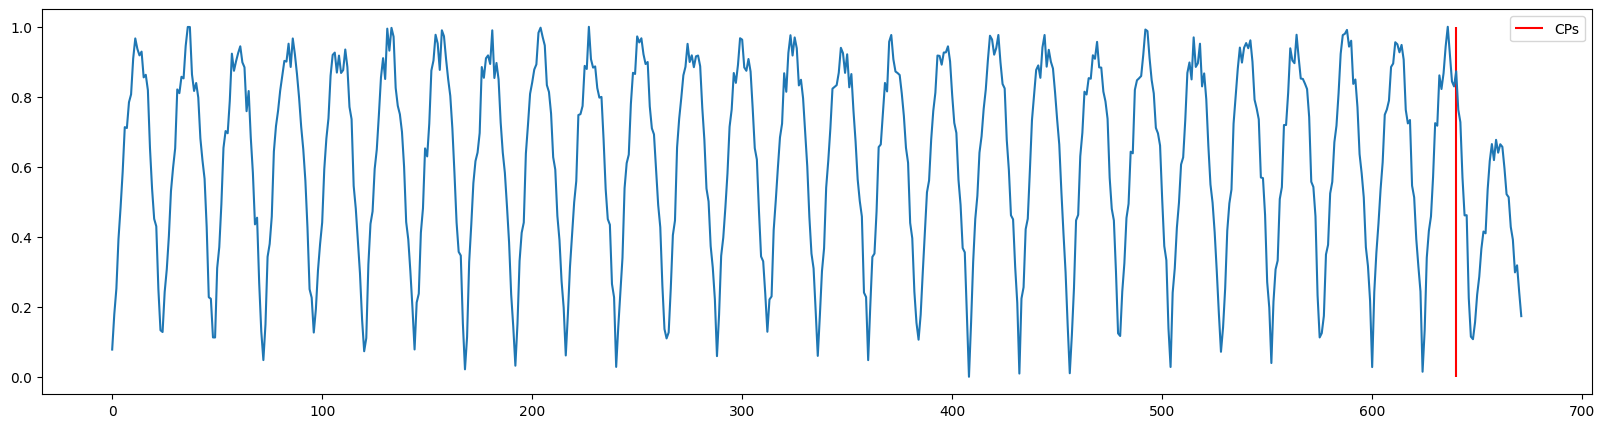

In [57]:
plt.figure(figsize=(20,5))
plt.vlines(list_of_filtered_cps,
           min(data.sinusoid_values_from_an_object),
           max(data.sinusoid_values_from_an_object),
          color='r',
          label='CPs')
plt.plot(data.values)
plt.legend()